In [ ]:
#bu basic model

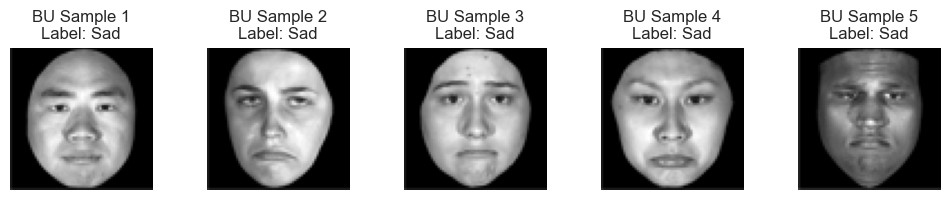

Label distribution:
Sad: 324 images
Fear: 324 images
Surprise: 321 images
Neutral: 81 images
Anger: 324 images
Joy: 324 images
Disgust: 324 images
Running configuration: No Data Augmentation
Test Accuracy: 64.44%
Precision: 0.94
Recall: 0.89
F1 Score: 0.92

Summary of Results:
Configuration 1: No Data Augmentation
Test Accuracy: 64.44%
Precision: 0.94
Recall: 0.89
F1 Score: 0.92


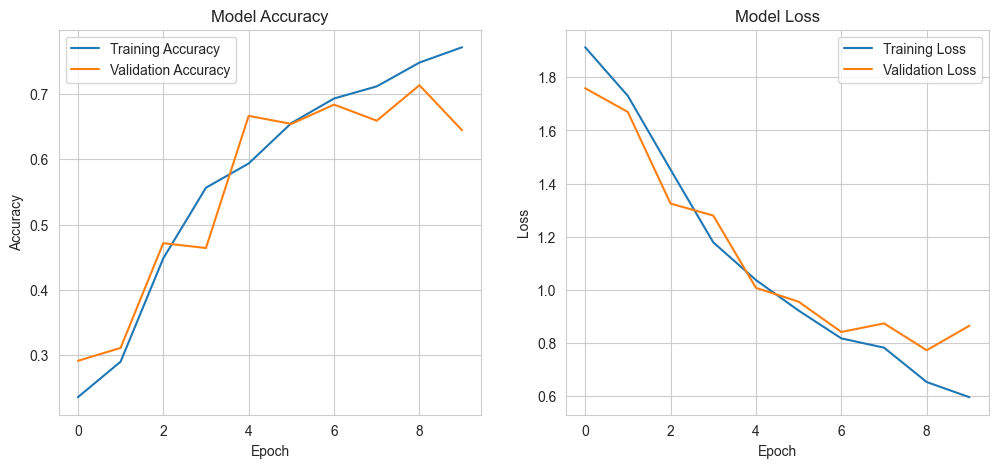

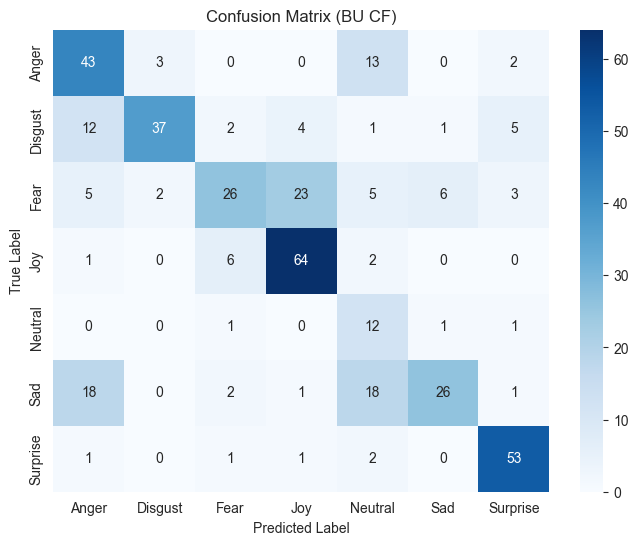

In [1]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the BU_3DFE dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):  # Check for .bmp files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Display some sample images with their labels
num_samples = 5
plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(images[i].reshape(64, 64), cmap='gray')
    plt.title(f"BU Sample {i+1}\nLabel: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# No data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "horizontal_flip": False
}

print(f"Running configuration: No Data Augmentation")

# Create the model
model = create_model()

# Define data augmentation configuration (with no augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'No Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix (BU CF)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (BU CF)")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


summary of the architecture, parameters, and important elements used in the above BU_3DFE code:

### **CNN Architecture:**
- **Input Layer**:
- Input shape: `(64, 64, 1)` for 64x64 grayscale images.
- **First Convolutional Layer**:
- 32 filters, kernel size of `(3x3)`, ReLU activation function.
- **First MaxPooling Layer**:
- Pool size of `(2x2)`.
- **Second Convolutional Layer**:
- 64 filters, kernel size of `(3x3)`, ReLU activation function.
- **Second MaxPooling Layer**:
- Pool size of `(2x2)`.
- **Flatten Layer**:
- Converts the 2D feature maps into a 1D vector.
- **Dense Layer**:
- 100 neurons, ReLU activation.
- **Output Layer**:
- Number of neurons equal to the number of unique labels (classes), softmax activation function.

### **Parameters and Important Elements:**
- **Dataset**:
- **Images**: Loaded from the BU_3DFE dataset, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Labels**: Extracted from folder names, encoded using `LabelEncoder`, and converted to one-hot encoding.
- **Data Splitting**: 80% training, 20% testing using `train_test_split`.
- **Class Weights**: Computed to handle class imbalance.

- **Data Augmentation**:
- No data augmentation applied (`shear_range=0.0`, `zoom_range=0.0`, `rotation_range=0`, `width_shift_range=0.0`, `height_shift_range=0.0`, `horizontal_flip=False`).

- **Training**:
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.
- **Epochs**: 10.
- **Batch Size**: 32.
- **Early Stopping**: Not implemented.

- **Evaluation Metrics**:
- **Test Accuracy**: Accuracy on the test set.
- **Precision, Recall, F1 Score**: Calculated to evaluate model performance.
- **Confusion Matrix**: Used to visualize classification results.

- **Visualization**:
- **Accuracy and Loss Plots**: Training and validation accuracy/loss over epochs.
- **Confusion Matrix**: Displayed using a heatmap.

This code is focused on training a simple CNN on the BU_3DFE dataset with no data augmentation, evaluating its performance using standard classification metrics and visualizations.

In [2]:
#bu aug

Label distribution:
Sad: 324 images
Fear: 324 images
Surprise: 321 images
Neutral: 81 images
Anger: 324 images
Joy: 324 images
Disgust: 324 images


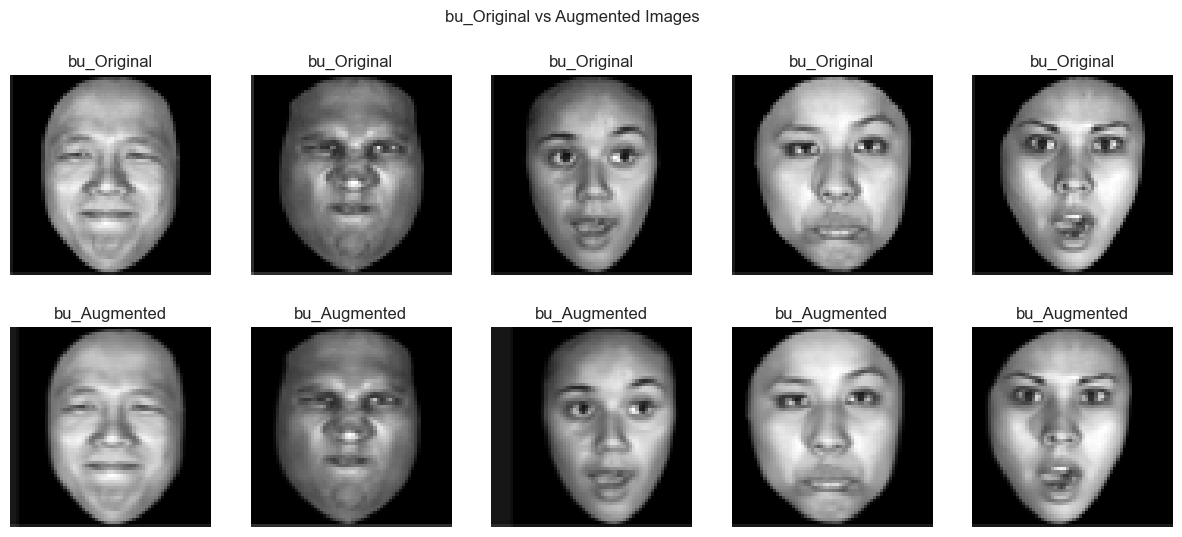

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1648 - loss: 1.9900 - val_accuracy: 0.3111 - val_loss: 1.9016
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2112 - loss: 1.9458 - val_accuracy: 0.3457 - val_loss: 1.6684
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3440 - loss: 1.6538 - val_accuracy: 0.4370 - val_loss: 1.4443
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4343 - loss: 1.4747 - val_accuracy: 0.4444 - val_loss: 1.3516
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4876 - loss: 1.2910 - val_accuracy: 0.5728 - val_loss: 1.1219
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5549 - loss: 1.1907 - val_accuracy: 0.5654 - val_loss: 1.1247
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5846 - loss: 1.1196 - val_accuracy: 0.5012 - val_loss: 1.2643
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5893 - loss: 1.0472 - val_accuracy: 0.6370 - v

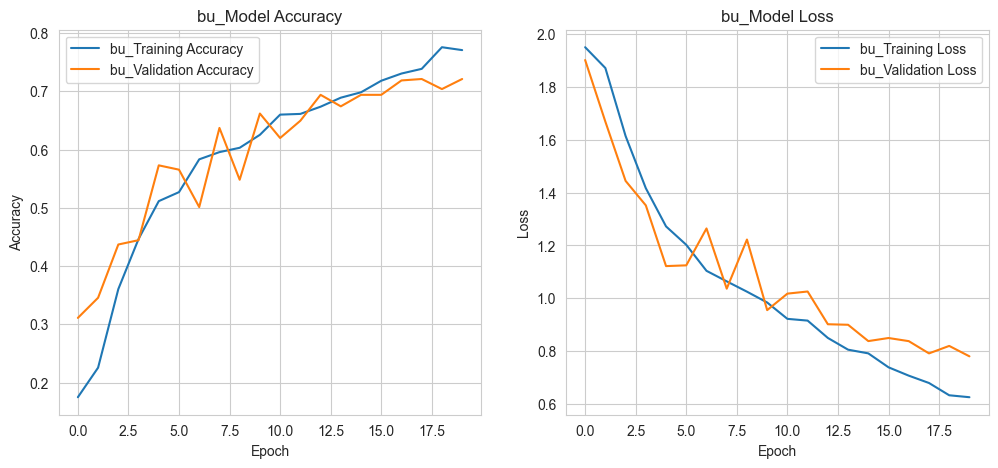

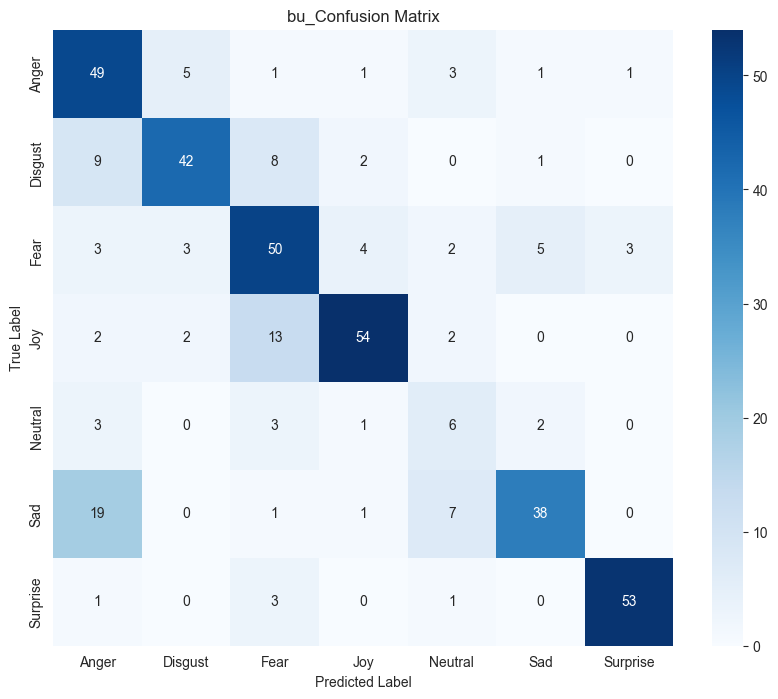

In [5]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the BU_3DFE dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):  # Check for .bmp files
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')  # Convert to grayscale
                    img = img.resize((64, 64))  # Resize to 64x64 for consistency
                    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img_array)
                    labels.append(label_folder)  # The folder name is the label
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# data augmentation configuration
config = {
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.1,
    "horizontal_flip": False
}

# Create the model
model = create_model()

# Define data augmentation configuration (augmentation)
datagen = ImageDataGenerator(
    shear_range=config["shear_range"],
    zoom_range=config["zoom_range"],
    rotation_range=config["rotation_range"],
    width_shift_range=config["width_shift_range"],
    height_shift_range=config["height_shift_range"],
    horizontal_flip=config["horizontal_flip"]
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Visualize some augmented images alongside the original images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original image
    axes[0, i].imshow(X_train[i].reshape(64, 64), cmap='gray')
    axes[0, i].set_title("bu_Original")
    axes[0, i].axis('off')

    # Augmented image
    augmented_image = datagen.random_transform(X_train[i])
    axes[1, i].imshow(augmented_image.reshape(64, 64), cmap='gray')
    axes[1, i].set_title("bu_Augmented")
    axes[1, i].axis('off')

plt.suptitle('bu_Original vs Augmented Images')
plt.show()

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=20,
    class_weight=class_weights_dict,
    verbose=1  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'Data Augmentation',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='bu_Training Accuracy')
plt.plot(history.history['val_accuracy'], label='bu_Validation Accuracy')
plt.title('bu_Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='bu_Training Loss')
plt.plot(history.history['val_loss'], label='bu_Validation Loss')
plt.title('bu_Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('bu_Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


summary of the architecture, parameters, and important elements used in the above BU_3DFE code with data augmentation:

### **CNN Architecture:**
- **Input Layer**:
- Input shape: `(64, 64, 1)` for 64x64 grayscale images.
- **First Convolutional Layer**:
- 32 filters, kernel size of `(3x3)`, ReLU activation function.
- **First MaxPooling Layer**:
- Pool size of `(2x2)`.
- **Second Convolutional Layer**:
- 64 filters, kernel size of `(3x3)`, ReLU activation function.
- **Second MaxPooling Layer**:
- Pool size of `(2x2)`.
- **Flatten Layer**:
- Converts the 2D feature maps into a 1D vector.
- **Dense Layer**:
- 100 neurons, ReLU activation.
- **Output Layer**:
- Softmax activation with a number of neurons equal to the number of unique labels (classes).

### **Parameters and Important Elements:**
- **Dataset**:
- **Images**: Loaded from the BU_3DFE dataset, converted to grayscale, resized to 64x64 pixels, and normalized to [0, 1].
- **Labels**: Extracted from folder names, encoded using `LabelEncoder`, and converted to one-hot encoding.
- **Data Splitting**: 80% training, 20% testing using `train_test_split`.
- **Class Weights**: Computed to handle class imbalance.

- **Data Augmentation**:
- **Configuration**: Height shift range of 0.1 (`height_shift_range=0.1`) and other augmentation parameters set to zero or `False`.
- **Visualization**: The code visualizes some original images alongside their augmented versions.

- **Training**:
- **Optimizer**: Adam.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.
- **Epochs**: 20.
- **Batch Size**: 32.

- **Evaluation Metrics**:
- **Test Accuracy**: Evaluated on the test set.
- **Precision, Recall, F1 Score**: Calculated to provide detailed performance metrics.
- **Confusion Matrix**: Generated to visualize classification performance.

- **Visualization**:
- **Original vs. Augmented Images**: The code displays original images and their augmented versions side by side.
- **Accuracy and Loss Plots**: Training and validation accuracy/loss over epochs are plotted.
- **Confusion Matrix**: Displayed using a heatmap to show true vs. predicted labels.

This code trains a CNN on the BU_3DFE dataset with specific data augmentation applied and evaluates its performance through multiple metrics and visualizations. The focus on augmentation and careful monitoring of metrics helps ensure robust model performance.

In [6]:
#bu_optimization

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1482 - loss: 1.9853 - val_accuracy: 0.2198 - val_loss: 1.9316
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2012 - loss: 1.9570 - val_accuracy: 0.2494 - val_loss: 1.8769
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2674 - loss: 1.8387 - val_accuracy: 0.3358 - val_loss: 1.6967
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3140 - loss: 1.7583 - val_accuracy: 0.4543 - val_loss: 1.5245
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3678 - loss: 1.6497 - val_accuracy: 0.4815 - val_loss: 1.4616
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4508 - loss: 1.5107 - val_accuracy: 0.4691 - val_loss: 1.3061
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4958 - loss: 1.3862 - val_accuracy: 0.4889 - val_loss: 1.3565
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4736 - loss: 1.3876 - val_accuracy: 0.5605 - v

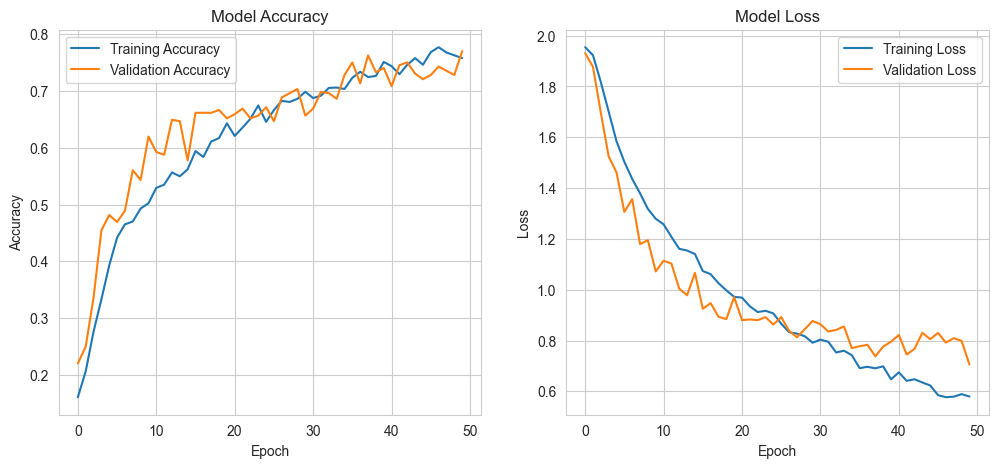

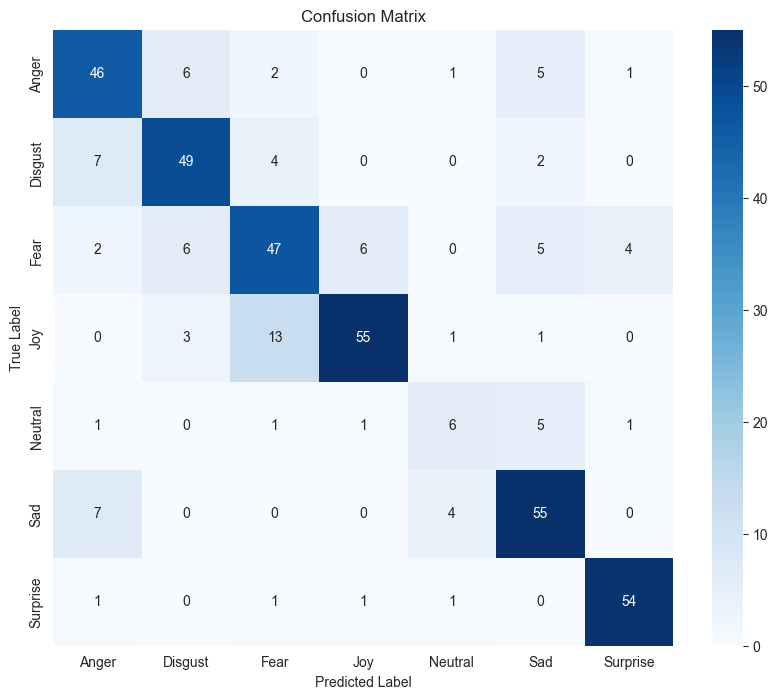

In [7]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'C:/Users/user/Downloads/Thesis/linda_trials/BU_3DFE_Database_sorted'

# Function to load images and extract labels
def load_images_and_labels(base_folder):
    images = []
    labels = []
    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith('.bmp'):
                    image_file = os.path.join(label_path, filename)
                    img = Image.open(image_file).convert('L')
                    img = img.resize((64, 64))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label_folder)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

# Use the given configuration
config = {
    'conv_layers': 2,
    'filters': 64,
    'dense_layers': 1,
    'dense_units': 64,
    'dropout': 0.3,
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'activation': 'relu',
    'optimizer': 'adam'
}

# Define and compile the CNN model
model = Sequential()
model.add(InputLayer(input_shape=(64, 64, 1)))
for _ in range(config['conv_layers']):
    model.add(Conv2D(config['filters'], (3, 3), activation=config['activation']))
    model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
for _ in range(config['dense_layers']):
    model.add(Dense(config['dense_units'], activation=config['activation']))
    model.add(Dropout(config['dropout']))
model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

# Select optimizer
optimizer_instance = Adam(learning_rate=config['learning_rate'])

model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=config['batch_size']),
                    validation_data=(X_test, y_test),
                    epochs=config['epochs'],
                    class_weight=class_weights_dict,
                    verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
precision.update_state(true_classes, predicted_classes)
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Print the metrics
print(f"Metrics - Accuracy: {test_acc*100:.2f}%, Precision: {precision.result().numpy():.4f}, Recall: {recall.result().numpy():.4f}, F1 Score: {f1_score:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


summary of the key aspects of the above code:

### **Dataset Preparation:**
- **Images**: Loaded from the BU_3DFE dataset, converted to grayscale, resized to 64x64 pixels, and normalized to a range of [0, 1].
- **Labels**: Extracted from folder names, encoded using `LabelEncoder`, and converted to one-hot encoding.
- **Data Splitting**: 80% of the data is used for training, and 20% for testing.

### **Class Weights:**
- **Class Weights**: Calculated to handle class imbalance, using `class_weight.compute_class_weight` from `sklearn`.

### **Data Augmentation:**
- **Configuration**:
  - **Height Shift Range**: 0.1
  - Other augmentations (shear, zoom, rotation, width shift, and horizontal flip) are set to zero or `False`.
- **Implementation**: The augmentation is applied using `ImageDataGenerator`.

### **CNN Model Architecture:**
- **Input Layer**: Accepts input of shape `(64, 64, 1)` for grayscale images.
- **Convolutional Layers**: 
  - 2 convolutional layers, each with 64 filters, `(3x3)` kernel size, and ReLU activation.
  - MaxPooling layers with a pool size of `(2x2)` follow each convolutional layer.
- **Flatten Layer**: Converts the 2D feature maps into a 1D vector.
- **Dense Layers**: 
  - 1 dense layer with 64 units and ReLU activation.
  - Dropout of 0.3 is applied to reduce overfitting.
- **Output Layer**: 
  - Softmax activation with the number of neurons equal to the number of unique classes.

### **Training Configuration:**
- **Optimizer**: Adam with a learning rate of 0.001.
- **Loss Function**: Categorical cross-entropy.
- **Metrics**: Accuracy.
- **Epochs**: 50.
- **Batch Size**: 32.

### **Model Training and Evaluation:**
- The model is trained using the data augmentation configuration and class weights for up to 50 epochs.
- **Evaluation Metrics**:
  - **Test Accuracy**: Calculated on the test set.
  - **Precision, Recall, F1 Score**: Calculated using TensorFlow's built-in metrics.

### **Visualization:**
- **Accuracy and Loss Plots**: Displayed for both training and validation over epochs.
- **Confusion Matrix**: Generated and displayed using a heatmap to show the performance of the model across different classes.

This summary captures the essential components of the model architecture, data augmentation strategy, training process, and evaluation methods used in the code.